<a href="https://colab.research.google.com/github/Tomokish/NLP/blob/main/NLP_End_Module_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
from google.colab import drive
import os

drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Question_Answer_Dataset_v1.2'

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"The dataset path does not exist: {dataset_path}")
else:
    print(f"Dataset path set successfully: {dataset_path}")
    print(os.listdir(dataset_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset path set successfully: /content/drive/MyDrive/Question_Answer_Dataset_v1.2
['LICENSE-S08,S09', 'README.v1.2', 'S09', 'S08', 'S10']


#Import libraries

In [116]:
    import os
    import numpy as np
    import pandas as pd
    import re
    import string
    import nltk
    from nltk.corpus import stopwords
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error, mean_absolute_error, r2_score
    from tensorflow.keras.utils import plot_model, to_categorical
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Embedding, LSTM, Attention, Dense, Concatenate, Lambda, TimeDistributed, Dropout, RepeatVector
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras import layers
    import tensorflow as tf
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    import pickle
    from google.colab import drive
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow import keras
    from collections import Counter
    import matplotlib.pyplot as plt
    import seaborn as sns

#Setup GPU

In [117]:
import tensorflow as tf

# Check GPUs
gpus = tf.config.list_physical_devices('GPU')

print("Num GPUs Available:", len(gpus))
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Available GPUs:", gpus)  # This will print the list of GPUs now that it's defined
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected, running on CPU.")

Num GPUs Available: 0
No GPU detected, running on CPU.


#preview data

In [118]:
import os
import pandas as pd

dataset_path = '/content/drive/MyDrive/Question_Answer_Dataset_v1.2'
folders = ['S08', 'S09', 'S10']

# Iterate over folders and preview data
for folder in folders:
    file_path = os.path.join(dataset_path, folder, 'question_answer_pairs.txt')
    try:
        if os.path.exists(file_path):
            data = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1', quoting=3)

            # Preview raw data
            print(f"\n--- Raw Data Sample from {folder} ---")
            print(data[['Question', 'Answer']].head(5))

            # Check for special characters
            questions_chars = set(''.join(data['Question'].dropna()))
            answers_chars = set(''.join(data['Answer'].dropna()))

            print(f"\nUnique Characters in Questions ({folder}):")
            print(questions_chars)

            print(f"\nUnique Characters in Answers ({folder}):")
            print(answers_chars)
        else:
            print(f"Error: File not found at {file_path}")

    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")


--- Raw Data Sample from S08 ---
                                            Question Answer
0  Was Abraham Lincoln the sixteenth President of...    yes
1  Was Abraham Lincoln the sixteenth President of...   Yes.
2  Did Lincoln sign the National Banking Act of 1...    yes
3  Did Lincoln sign the National Banking Act of 1...   Yes.
4                   Did his mother die of pneumonia?     no

Unique Characters in Questions (S08):
{'u', '3', '2', 'R', '¤', 'Y', 'i', '8', "'", '1', '#', 'z', 'A', 'Q', 'W', ':', 'N', '%', 'j', 'g', 'Ä', 'C', 's', 'I', 'b', 'K', '-', 't', 'q', 'F', 'f', '9', 'l', 'e', 'y', 'p', 'P', 'Ã', '0', 'J', '$', '7', 'U', '5', '&', '.', '©', 'm', 'w', 'd', '\x87', 'L', 'G', 'a', ';', 'x', 'h', '`', 'n', 'S', 'V', 'B', 'H', 'c', '4', 'O', 'r', 'v', ')', 'M', '(', '"', 'D', 'o', '\x85', 'k', ' ', 'T', ',', 'X', '6', 'E', 'Z', '?'}

Unique Characters in Answers (S08):
{'u', '3', '2', '*', 'R', 'Y', 'i', '8', "'", '1', '#', 'z', 'A', 'Q', 'W', ':', '\\', 'N', '÷', '%', '

Clean data

In [120]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\x00-\x7f]', '', text)
    text = re.sub(r'.*?', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

dataset_path = '/content/drive/MyDrive/Question_Answer_Dataset_v1.2'
folders = ['S08', 'S09', 'S10']
all_data = pd.DataFrame()

load Data S8,S9,S10 and concatenate data

In [ ]:
for folder in folders:
    file_path = os.path.join(dataset_path, folder, 'question_answer_pairs.txt')
    if os.path.exists(file_path):
        data = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1', quoting=3)
        all_data = pd.concat([all_data, data], ignore_index=True)
print(all_data.columns)


Index(['ArticleTitle', 'Question', 'Answer', 'DifficultyFromQuestioner',
       'DifficultyFromAnswerer', 'ArticleFile'],
      dtype='object')


In [ ]:
cleaned_data = all_data.dropna(subset=['Question', 'Answer'])

# Preprocess text clearly (apply your defined preprocess_text function)
cleaned_data['Question'] = cleaned_data['Question'].apply(preprocess_text)
cleaned_data['Answer'] = cleaned_data['Answer'].apply(preprocess_text)

# Splitting into train, validation, test sets clearly:
train_data, temp_data = train_test_split(cleaned_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train set size: {train_data.shape}")
print(f"Validation set size: {val_data.shape}")
print(f"Test set size: {test_data.shape}")

Train set size: (2394, 6)
Validation set size: (513, 6)
Test set size: (513, 6)


<ipython-input-6-62aaae04eedd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Question'] = cleaned_data['Question'].apply(preprocess_text)
<ipython-input-6-62aaae04eedd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Answer'] = cleaned_data['Answer'].apply(preprocess_text)


#Tokenize

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_data['Question'].tolist() + cleaned_data['Answer'].tolist())

# Add special tokens
word_index = tokenizer.word_index
next_index = len(word_index) + 1
word_index['starttoken'] = next_index
next_index += 1
word_index['endtoken'] = next_index
tokenizer.word_index = word_index
tokenizer.index_word = {v: k for k, v in word_index.items()}

# Calculate vocabulary size AFTER adding special tokens
vocab_size = len(tokenizer.word_index) + 1

# Prepare answers with special tokens
train_answers_with_tokens = ['starttoken ' + answer + ' endtoken' for answer in train_data['Answer']]
val_answers_with_tokens = ['starttoken ' + answer + ' endtoken' for answer in val_data['Answer']]
test_answers_with_tokens = ['starttoken ' + answer + ' endtoken' for answer in test_data['Answer']]

max_question_len = max(len(seq) for seq in tokenizer.texts_to_sequences(cleaned_data['Question'].tolist()))
max_answer_len = max(len(seq) for seq in tokenizer.texts_to_sequences(train_answers_with_tokens + val_answers_with_tokens + test_answers_with_tokens))

def tokenize_and_pad(data, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(data)
    return pad_sequences(sequences, maxlen=max_len, padding='post')

train_questions = tokenize_and_pad(train_data['Question'], tokenizer, max_question_len)
val_questions = tokenize_and_pad(val_data['Question'], tokenizer, max_question_len)
test_questions = tokenize_and_pad(test_data['Question'], tokenizer, max_question_len)

train_answers = tokenize_and_pad(train_answers_with_tokens, tokenizer, max_answer_len)
val_answers = tokenize_and_pad(val_answers_with_tokens, tokenizer, max_answer_len)
test_answers = tokenize_and_pad(test_answers_with_tokens, tokenizer, max_answer_len)

#Seq2Seq without Attention

Define Model architecture

In [ ]:
encoder_inputs_1 = Input(shape=(max_question_len,))
encoder_embedding_1 = Embedding(vocab_size, 256, mask_zero=True)(encoder_inputs_1)
encoder_lstm_1 = LSTM(256, return_state=True, dropout=0.3)
encoder_outputs_1, state_h_1, state_c_1 = encoder_lstm_1(encoder_embedding_1)

decoder_inputs_1 = Input(shape=(max_answer_len,))
decoder_embedding_1 = Embedding(vocab_size, 256, mask_zero=True)(decoder_inputs_1)
decoder_lstm_1 = LSTM(256, return_sequences=True, return_state=True, dropout=0.3)
decoder_outputs_1, _, _ = decoder_lstm_1(decoder_embedding_1, initial_state=[state_h_1, state_c_1])
decoder_dense_1 = Dense(vocab_size, activation="softmax")
decoder_outputs_1 = decoder_dense_1(decoder_outputs_1)

model_without_attention = Model([encoder_inputs_1, decoder_inputs_1], decoder_outputs_1)
model_without_attention.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model_without_attention.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 43)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 157)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 43, 256)        │      1,376,768 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 43)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 157, 256)       │      1,376,768 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 256), (None,   │        525,312 │ embedding[0][0],       │
│                           │ 256), (None, 256)]     │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 157, 256),     │        525,312 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 157, 5378)      │      1,382,146 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,186,306 (19.78 MB)

 Trainable params: 5,186,306 (19.78 MB)

 Non-trainable params: 0 (0.00 B)

Model Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_without_attention.fit(
    [train_questions, train_answers],
    np.expand_dims(train_answers, axis=-1),
    batch_size=64,
    epochs=10,
    validation_data=([val_questions, val_answers], np.expand_dims(val_answers, axis=-1)),
    callbacks=[early_stopping]
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 7.6037 - val_loss: 4.8844
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 4.3735 - val_loss: 4.2751
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 3.9753 - val_loss: 4.0273
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 3.6065 - val_loss: 3.9027
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 3.4916 - val_loss: 3.7991
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 3.2243 - val_loss: 3.7120
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 3.1502 - val_loss: 3.6428
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 3.0543 - val_loss: 3.5797
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 2.9728 - val_loss: 3.5209
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 2.8110 - val_loss: 3.4686


Evaluate

In [ ]:
loss = model_without_attention.evaluate(
    [test_questions, test_answers[:, :-1]],
    test_answers[:, 1:, np.newaxis]
)
print(f"Test loss: {loss}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 12.2422
Test loss: 12.264827728271484


#backup part for JC model

Seq2Seq Model with Bahdanau Attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, axis=1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * values, axis=1)
        return context_vector, attention_weights

Encoder

In [ ]:
encoder_inputs_2 = Input(shape=(max_question_len,))
encoder_embedding_2 = Embedding(vocab_size, 256, mask_zero=True)(encoder_inputs_2)
encoder_lstm_2 = LSTM(256, return_sequences=True, return_state=True, dropout=0.3)
encoder_outputs_2, state_h_2, state_c_2 = encoder_lstm_2(encoder_embedding_2)

Decoder

In [ ]:
decoder_inputs_2 = Input(shape=(max_answer_len,))
decoder_embedding_2 = Embedding(vocab_size, 256, mask_zero=True)(decoder_inputs_2)
decoder_lstm_2 = LSTM(256, return_sequences=True, return_state=True, dropout=0.3)
decoder_outputs_2, _, _ = decoder_lstm_2(decoder_embedding_2, initial_state=[state_h_2, state_c_2])

Attention & ouput layer

In [ ]:
attention_layer = BahdanauAttention(256)
context_vector, attention_weights = attention_layer(state_h_2, encoder_outputs_2)

context_vector_repeated = Lambda(lambda x: tf.repeat(tf.expand_dims(x[0], axis=1), tf.shape(x[1])[1], axis=1))(
    [context_vector, decoder_outputs_2]
)

decoder_combined_context = Concatenate(axis=-1)([context_vector_repeated, decoder_outputs_2])
decoder_combined_context = Dense(256, activation="tanh")(decoder_combined_context)
output_layer = Dense(vocab_size, activation="softmax")
decoder_outputs_2 = output_layer(decoder_combined_context)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'lambda' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
# Create model
model_with_attention = Model([encoder_inputs_2, decoder_inputs_2], decoder_outputs_2)
model_with_attention.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model_with_attention.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 43)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 43, 256)        │      1,376,768 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 43)             │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 157)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 43, 256),      │        525,312 │ embedding_2[0][0],     │
│                           │ (None, 256), (None,    │                │ not_equal_2[0][0]      │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 157, 256)       │      1,376,768 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bahdanau_attention        │ [(None, 256), (None,   │        131,841 │ lstm_2[0][1],          │
│ (BahdanauAttention)       │ 43, 1)]                │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 157, 256),     │        525,312 │ embedding_3[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 157)            │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 157, 256)       │              0 │ bahdanau_attention[0]… │
│                           │                        │                │ lstm_3[0][0],          │
│                           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 157, 512)       │              0 │ lambda[0][0],          │
│                           │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 157, 256)       │        131,328 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 157, 5378)      │      1,382,146 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,449,475 (20.79 MB)

 Trainable params: 5,449,475 (20.79 MB)

 Non-trainable params: 0 (0.00 B)

Model training

In [ ]:
model_with_attention.fit(
    [train_questions, train_answers],
    np.expand_dims(train_answers, axis=-1),
    batch_size=64,
    epochs=10,
    validation_data=([val_questions, val_answers], np.expand_dims(val_answers, axis=-1)),
    callbacks=[early_stopping]
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 4.2333 - val_loss: 0.2281
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.2099 - val_loss: 0.1903
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.1841 - val_loss: 0.1761
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.1651 - val_loss: 0.1616
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.1533 - val_loss: 0.1548
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.1462 - val_loss: 0.1502
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.1270 - val_loss: 0.1454
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.1414 - val_loss: 0.1421
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.1304 - val_loss: 0.1399
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.1329 - val_loss: 0.1383


Inference model setup without attention

In [ ]:
# Encoder Model for Inference (Without Attention)
encoder_model_1 = Model(encoder_inputs_1, [state_h_1, state_c_1])

# Decoder Model for Inference (Without Attention)
decoder_state_input_h_1 = Input(shape=(256,))
decoder_state_input_c_1 = Input(shape=(256,))
decoder_inputs_1_inf = Input(shape=(1,))

decoder_embedding_1_inf = Embedding(vocab_size, 256, mask_zero=True)(decoder_inputs_1_inf)
decoder_outputs_1_inf, state_h_1_inf, state_c_1_inf = decoder_lstm_1(
    decoder_embedding_1_inf, initial_state=[decoder_state_input_h_1, decoder_state_input_c_1]
)
decoder_outputs_1_inf = decoder_dense_1(decoder_outputs_1_inf)

decoder_model_1 = Model(
    [decoder_inputs_1_inf, decoder_state_input_h_1, decoder_state_input_c_1],
    [decoder_outputs_1_inf, state_h_1_inf, state_c_1_inf]
)

Inference model setup with attention

In [ ]:
# Encoder
encoder_model_2 = Model(encoder_inputs_2, [encoder_outputs_2, state_h_2, state_c_2])

# Decoder
decoder_state_input_h_2 = Input(shape=(256,))
decoder_state_input_c_2 = Input(shape=(256,))
encoder_outputs_input = Input(shape=(max_question_len, 256))
decoder_inputs_2_inf = Input(shape=(1,))

# Embed the single input token
decoder_embedding_2_inf = Embedding(vocab_size, 256, mask_zero=True)(decoder_inputs_2_inf)

# Run LSTM
decoder_outputs_2_inf, state_h_2_inf, state_c_2_inf = decoder_lstm_2(
    decoder_embedding_2_inf,
    initial_state=[decoder_state_input_h_2, decoder_state_input_c_2]
)

# Apply the same attention mechanism used in training
context_vector_inf, _ = attention_layer(state_h_2_inf, encoder_outputs_input)

# Create a repeated context vector for concatenation
context_vector_inf_repeated = Lambda(lambda x: tf.expand_dims(x, axis=1))(context_vector_inf)

# Combine context vector with decoder output
combined_context = Concatenate(axis=-1)([decoder_outputs_2_inf, context_vector_inf_repeated])
output_inf = Dense(256, activation="tanh")(combined_context)
output_inf = output_layer(output_inf)

# Create decoder model for inference
decoder_model_2 = Model(
    [decoder_inputs_2_inf, encoder_outputs_input, decoder_state_input_h_2, decoder_state_input_c_2],
    [output_inf, state_h_2_inf, state_c_2_inf]
)

Text Generation Functions without attention

In [ ]:
def decode_sequence_without_attention(input_seq, max_tokens=None):
    if max_tokens is None:
        max_tokens = max_answer_len

    # Encode the input sequence
    state_h, state_c = encoder_model_1.predict(input_seq)

    # Start with the start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['starttoken']

    decoded_sentence = ""

    for _ in range(min(max_tokens, max_answer_len)):
        # Generate next token
        output_tokens, h, c = decoder_model_1.predict([target_seq, state_h, state_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')

        # Exit condition: end token or unknown token
        if sampled_word == 'endtoken' or sampled_word == '':
            break

        decoded_sentence += ' ' + sampled_word

        # Update the target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        state_h, state_c = h, c

    return decoded_sentence.strip()

Test Generation Functions with attention

In [ ]:
def decode_sequence_with_attention(input_seq, max_tokens=None):
    if max_tokens is None:
        max_tokens = max_answer_len

    # Encode the input sequence
    encoder_out, state_h, state_c = encoder_model_2.predict(input_seq)

    # Start with the start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['starttoken']

    decoded_sentence = []

    for _ in range(min(max_tokens, max_answer_len)):
        # Generate next token with attention
        output_tokens, state_h, state_c = decoder_model_2.predict(
            [target_seq, encoder_out, state_h, state_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')

        # Exit condition: end token or unknown token
        if sampled_word == 'endtoken' or sampled_word == '':
            break

        decoded_sentence.append(sampled_word)

        # Update the target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return ' '.join(decoded_sentence)

BLEU Scores

In [ ]:
def evaluate_bleu(test_data, tokenizer, max_question_len, decode_fn, model_name, sample_size=50, max_tokens=30):
    """
    Evaluate BLEU score on a sample of test data
    """
    # Take a small random sample
    if sample_size and sample_size < len(test_data):
        test_sample = test_data.sample(sample_size, random_state=42)
    else:
        test_sample = test_data

    print(f"Evaluating {model_name} on {len(test_sample)} test examples...")

    bleu_scores = []
    smooth_fn = SmoothingFunction().method4

    for i, (index, row) in enumerate(test_sample.iterrows()):
        # Show progress every 10 examples
        if i % 10 == 0:
            print(f"Processing example {i}/{len(test_sample)}")

        input_seq = tokenizer.texts_to_sequences([row['Question']])
        input_seq = pad_sequences(input_seq, maxlen=max_question_len, padding='post')

        decoded_sentence = decode_fn(input_seq, max_tokens=max_tokens)

        # Calculate BLEU score
        reference = [row['Answer'].split()]
        candidate = decoded_sentence.split()
        bleu = sentence_bleu(reference, candidate, smoothing_function=smooth_fn)
        bleu_scores.append(bleu)

    average_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
    print(f"Average BLEU Score for {model_name}: {average_bleu:.4f}")
    return average_bleu

# Run evaluation
sample_size = 50
max_tokens = 20

bleu_without_attention = evaluate_bleu(
    test_data, tokenizer, max_question_len, decode_sequence_without_attention,
    "Seq2Seq Without Attention", sample_size=sample_size, max_tokens=max_tokens
)

bleu_with_attention = evaluate_bleu(
    test_data, tokenizer, max_question_len, decode_sequence_with_attention,
    "Seq2Seq With Attention", sample_size=sample_size, max_tokens=max_tokens
)

print(f"\nFinal BLEU Scores (based on {sample_size} samples):")
print(f"Seq2Seq Without Attention: {bleu_without_attention:.4f}")
print(f"Seq2Seq With Attention: {bleu_with_attention:.4f}")

Evaluating Seq2Seq Without Attention on 50 test examples...
Processing example 0/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/

#(Section 2): Build Seq2Seq Model Chatbot With Luong Attention

#(Step1): Load the Dataset (Question and Answer Dataset)

In [121]:
# Verify the Files

In [122]:
import os
file_path = "/content/drive/MyDrive/Question_Answer_Dataset_v1.2"
if os.path.exists(file_path):
  print('File Found')
else:
  print('File not Found, Check the path again.')
print(os .listdir(file_path))

File Found
['LICENSE-S08,S09', 'README.v1.2', 'S09', 'S08', 'S10']


In [123]:
# Loop through S08, S09, S10 and print their contect

In [124]:
for subdir in ["S08", "S09", "S10"]:
  subdir_path = os.path.join(file_path, subdir)
  print(f"Contents of {subdir}: {os.listdir(subdir_path)}\n")

Contents of S08: ['question_answer_pairs.txt', 'data']

Contents of S09: ['question_answer_pairs.txt', 'data']

Contents of S10: ['question_answer_pairs.txt', 'data']



In [126]:
# Define the File Path for all the three files

In [127]:
s08_file = "/content/drive/MyDrive/Question_Answer_Dataset_v1.2/S08/question_answer_pairs.txt"
s09_file = "/content/drive/MyDrive/Question_Answer_Dataset_v1.2/S09/question_answer_pairs.txt"
s10_file = "/content/drive/MyDrive/Question_Answer_Dataset_v1.2/S10/question_answer_pairs.txt"

In [128]:
# Read Few Lines of File S08

In [129]:
with open(s08_file, "r", encoding="utf-8", errors="ignore") as f:
  lines = f.readlines()

In [130]:
# Display first 10 lines to check the structure of the files
for line in lines[:10]:
  print(line.strip())

ArticleTitle	Question	Answer	DifficultyFromQuestioner	DifficultyFromAnswerer	ArticleFile
Abraham_Lincoln	Was Abraham Lincoln the sixteenth President of the United States?	yes	easy	easy	data/set3/a4
Abraham_Lincoln	Was Abraham Lincoln the sixteenth President of the United States?	Yes.	easy	easy	data/set3/a4
Abraham_Lincoln	Did Lincoln sign the National Banking Act of 1863?	yes	easy	medium	data/set3/a4
Abraham_Lincoln	Did Lincoln sign the National Banking Act of 1863?	Yes.	easy	easy	data/set3/a4
Abraham_Lincoln	Did his mother die of pneumonia?	no	easy	medium	data/set3/a4
Abraham_Lincoln	Did his mother die of pneumonia?	No.	easy	easy	data/set3/a4
Abraham_Lincoln	How many long was Lincoln's formal education?	18 months	medium	easy	data/set3/a4
Abraham_Lincoln	How many long was Lincoln's formal education?	18 months.	medium	medium	data/set3/a4
Abraham_Lincoln	When did Lincoln begin his political career?	1832	medium	easy	data/set3/a4


In [131]:
# Load all the into a DataFrame

In [133]:
def load_data():
  df_s08 = pd.read_csv(s08_file, sep="\t", encoding="ISO-8859-1", on_bad_lines='skip')
  df_s09 = pd.read_csv(s09_file, sep="\t", encoding="ISO-8859-1", on_bad_lines='skip')
  df_s10 = pd.read_csv(s10_file, sep="\t", encoding="ISO-8859-1", on_bad_lines='skip')

# Combine all the three datasets
  df_combined = pd.concat([df_s08, df_s09, df_s10], ignore_index=True)

  return df_combined

  # Now load the combined dataset
df_combined = load_data()

# Display the First Few rows
print(df_combined.head())

      ArticleTitle                                           Question Answer  \
0  Abraham_Lincoln  Was Abraham Lincoln the sixteenth President of...    yes   
1  Abraham_Lincoln  Was Abraham Lincoln the sixteenth President of...   Yes.   
2  Abraham_Lincoln  Did Lincoln sign the National Banking Act of 1...    yes   
3  Abraham_Lincoln  Did Lincoln sign the National Banking Act of 1...   Yes.   
4  Abraham_Lincoln                   Did his mother die of pneumonia?     no   

  DifficultyFromQuestioner DifficultyFromAnswerer   ArticleFile  
0                     easy                   easy  data/set3/a4  
1                     easy                   easy  data/set3/a4  
2                     easy                 medium  data/set3/a4  
3                     easy                   easy  data/set3/a4  
4                     easy                 medium  data/set3/a4  


#Load the Datasets

In [134]:
# Print the column
print(df_combined.columns)

Index(['ArticleTitle', 'Question', 'Answer', 'DifficultyFromQuestioner',
       'DifficultyFromAnswerer', 'ArticleFile'],
      dtype='object')


In [135]:
# Load the Conversations

In [136]:
def load_data(df_combined):
  conversations = []


  # Iterate through each row and combine 'Question' and 'Answer' to form a conversation

  for index, row in df_combined.iterrows():
    conversation = row['Question'] + "" + row['Answer'] # Combine Question and Answer
    conversations.append(conversation)

  return conversations

#(Step2): Data Cleaning and Preprocessing

In [137]:
# Data Cleaning

# Download stopwords if not already download
nltk.download('stopwords')

# Define the stop words
stop_words = set(stopwords.words('english'))

# Define clean text
def clean_text(text):
  """
  Clean the input list of words by:
  1. lowercase each word
  2. Removing non-alphabetic characters
  3. Removing stop words.
  """

  # Ensure the text is a string
  if not isinstance(text, list):
    return [] # Return empty list if not a list

  # Clean the test lower case, remove noise and unnecessary space
  cleaned_words = []
  for word in text:
    cleaned_word = word.lower()
    cleaned_word = re.sub(r"[^a-zA-Z]", "", cleaned_word)
    if cleaned_word and cleaned_word not in stop_words:
      cleaned_words.append(cleaned_word)   #text = re.sub(r"\s+", " ", text).strip()

  return cleaned_words

# Drop rows with missing values
df_combined.dropna(subset=['Question', 'Answer'], inplace=True)

# Define the Preprocessing
def preprocess_data(conversations):
  """This function takes a list of conversations (Questions and Answers),
  process them to remove unwanted Characters.
  """
  inputs, targets = [], []
  for i in range (len(conversations) - 1):

    # Claen the question and append it as input, answer as target
    question = conversations[i] if isinstance(conversations[i], str) else " " # Question
    answer = conversations[i + 1] if isinstance(conversations[i + 1], str) else " " # Answers

    # Clean the question and append it
    clean_input = clean_text(question.split())
    inputs.append(clean_input)

    # Clean the answer and append with <start> and <End>
    clean_target = "<start>" + " ".join(clean_text(answer.split())) + "<end>"
    targets.append(clean_target)

  return inputs, targets

# Example usage for Demo
conversations = ['How are you?', 'I am good, thank you!']
inputs, targets = preprocess_data(conversations)

print(inputs)
print(targets)

df_combined['Question'] = df_combined['Question'].apply(preprocess_text)
df_combined['Answer'] = df_combined['Answer'].apply(preprocess_text)

[[]]
['<start>good thank<end>']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [138]:
# Define questions and answers

questions = df_combined['Question'].values
answers = df_combined['Answer'].values

#(Step 3):Tokenizer, Sequence and Padding

In [141]:
# Create tokenizers for questions and answers
# Print first five questions and answer
print(type(questions))
print(questions[:5])
print(answers[:5])


<class 'numpy.ndarray'>
['was abraham lincoln the sixteenth president of the united states'
 'was abraham lincoln the sixteenth president of the united states'
 'did lincoln sign the national banking act of'
 'did lincoln sign the national banking act of'
 'did his mother die of pneumonia']
['yes' 'yes' 'yes' 'yes' 'no']


#Trained Questions and Answers

In [142]:
# Trained Questions
questions = df_combined['Question'].fillna('').tolist() # Fill missing values and convert to list
questions = [str(q) for q in questions] # convert all element to strings
tokenizer_q = tf.keras.preprocessing.text.Tokenizer(filters='')  # Tokenizer for Questions
tokenizer_q.fit_on_texts(questions)

# Trained Answers
answers = df_combined['Answer'].fillna('').tolist()  # Fill missing values and convert to list
answers = [str (a) for a in answers] # convert all elements to strings
tokenizer_a = tf.keras.preprocessing.text.Tokenizer(filters='') # Tokenizer for Answers
tokenizer_a.fit_on_texts(answers)

#Split the data into Training, Validation and Test Sets

In [146]:
# Split the datasets into training, validation and test sets
x_train, x_test, y_train, y_test = train_test_split(questions, answers, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Define tokenizer for input and output sequences, which represent our questions/x_train and answers/y_train
tokenizer = Tokenizer()

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Set the limit tokenize word
tokenizer_input = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer_ouput = Tokenizer(num_words=5000, oov_token="<OOV>")

# Fit the tokenizer on the training and validation data
tokenizer.fit_on_texts(questions) # fit the tokenizer on questions and answers
tokenizer.fit_on_texts(answers) #fit the tokinizer on validation data
tokenizer.fit_on_texts(y_val)

# To print out the length of Input and Output sequence
max_input_len = df_combined['Question'].apply(lambda x: len(x.split())).max()
max_output_len = df_combined['Answer'].apply(lambda x: len(x.split())).max()

# Convert input(questions) and output(answers) to sequences and Pad both input_seq & output_seq
input_seq = tokenizer_q.texts_to_sequences(questions) # x_train
output_seq = tokenizer_a.texts_to_sequences(answers)  # y_train

# Pad the input and output sequences.
input_seq_padded = pad_sequences(input_seq, maxlen=537, padding='post', truncating='post')
output_seq_padded = pad_sequences(output_seq, maxlen=537, padding='post', truncating='post')

max_input_len = min(max([len(seq) for seq in input_seq]), max([len(seq) for seq in output_seq]))
max_output_len = max_input_len # Make input seq/x_train and output seq/y_train sequel length equal

# Prepare target output with shifted sequence for decoder input
output_seq_decoder = output_seq_padded[:, :154]
output_seq_decoder = np.zeros_like(output_seq_padded)
output_seq_decoder[:, 1:] = output_seq_padded[:, :-1]

# Convert test y val labels into sequence of numbers
y_val_seq = tokenizer.texts_to_sequences(y_val)
max_output_len = max([len(seq) for seq in y_val_seq])

# Pad the y Val set to ensure uniformity
y_val_padded = pad_sequences(y_val_seq, maxlen=max_output_len, padding='post', truncating='post') # Add padding

print(f"Max input sequence length: {max_input_len}")
print(f"Max output sequence length: {max_output_len}")
print(f"Input sequennce shape(x_train/questions): {input_seq}")
print(f"Output sequence shape(y_train/answers): {output_seq}")
print(f"Input Sequence shape after padded: {input_seq_padded}")


Max input sequence length: 43
Max output sequence length: 38
Input sequennce shape(x_train/questions): [[7, 718, 90, 1, 1426, 57, 2, 1, 108, 113], [7, 718, 90, 1, 1426, 57, 2, 1, 108, 113], [8, 90, 719, 1, 137, 1427, 381, 2], [8, 90, 719, 1, 137, 1427, 381, 2], [8, 29, 238, 105, 2, 1428], [8, 29, 238, 105, 2, 1428], [11, 19, 62, 7, 834, 720, 382], [11, 19, 62, 7, 834, 720, 382], [17, 8, 90, 383, 29, 259, 721], [17, 8, 90, 383, 29, 259, 721], [4, 8, 1, 616, 1429, 381, 2, 835], [4, 8, 1, 616, 1429, 381, 2, 835], [20, 1430, 90, 836, 6, 1431], [20, 1430, 90, 836, 6, 1431], [17, 8, 1, 1432, 1433, 837, 31, 224, 7, 38], [17, 8, 1, 1432, 1433, 837, 31, 224, 7, 38], [8, 90, 1434, 109, 472, 1435, 5, 1, 428], [8, 90, 1434, 109, 472, 1435, 5, 1, 428], [7, 718, 90, 1, 36, 57, 2, 1, 108, 113], [7, 718, 90, 1, 36, 57, 2, 1, 108, 113], [8, 90, 838, 29, 259, 721, 5], [8, 90, 838, 29, 259, 721, 5], [8, 90, 296, 839, 1436, 1437, 1438], [8, 90, 296, 839, 1436, 1437, 1438], [37, 473, 7, 90, 38, 5], [37, 47

#Test  Questions and Answers After tokenized as the input to the Encoder

In [147]:
# Test the Question and Answer after tokenized
for i in range(5):
          print(f"questions{i+1}: {x_train[i]}")
          print(f"answers{i+1}: {y_train[i]}\n")
          print(y_val[:10])

questions1: where was isaac newton born
answers1: at woolsthorpe manor in woosthorpebycolsterworth

['days', 'yes', 'yes', 'yes', '', 'the definition of the electrostatic force of attraction and repulsion', 'yes', '', 'no', 'none']
questions2: where is finland located
answers2: northern europe

['days', 'yes', 'yes', 'yes', '', 'the definition of the electrostatic force of attraction and repulsion', 'yes', '', 'no', 'none']
questions3: are wolves built for stamina
answers3: yes

['days', 'yes', 'yes', 'yes', '', 'the definition of the electrostatic force of attraction and repulsion', 'yes', '', 'no', 'none']
questions4: how old was pascal when he died
answers4: 

['days', 'yes', 'yes', 'yes', '', 'the definition of the electrostatic force of attraction and repulsion', 'yes', '', 'no', 'none']
questions5: did pascal have poor health throughout his life
answers5: yes

['days', 'yes', 'yes', 'yes', '', 'the definition of the electrostatic force of attraction and repulsion', 'yes', '', 'no

In [148]:
# Print y_val
print(type(y_train))
print(type(x_train))
print(type(y_val))
print(y_val[:10])
print(y_train[:2])
print(x_train[:2])

<class 'list'>
<class 'list'>
<class 'list'>
['days', 'yes', 'yes', 'yes', '', 'the definition of the electrostatic force of attraction and repulsion', 'yes', '', 'no', 'none']
['at woolsthorpe manor in woosthorpebycolsterworth', 'northern europe']
['where was isaac newton born', 'where is finland located']


#(Step 5): Analyse the Dataset Distribution

In [149]:
# Analyse the Dataset Distribution

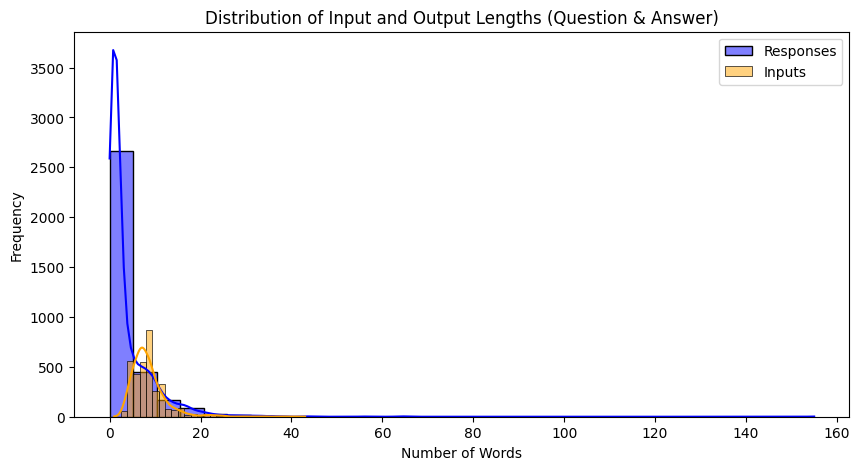

In [150]:
response_lengths = [len(text.split()) for text in answers]
input_lengths = [len(text.split()) for text in questions]

# Plot Response Length Distribution
plt.figure(figsize=(10, 5))
sns.histplot(response_lengths, bins=30, kde=True, color='blue', label='Responses')
sns.histplot(input_lengths, bins=30, kde=True, color='orange', label='Inputs')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Input and Output Lengths (Question & Answer)')
plt.legend()
plt.show()


#Check for the Vocabulary Sizes

In [151]:
vocab_size_input = len(tokenizer.word_index) + 1  # for padding token
vocab_size_output = len(tokenizer.word_index) + 1  # for padding token

print(f"Input Vocabulary Size: {vocab_size_input}")
print(f"Output Vocabulary Size: {vocab_size_output}")

Input Vocabulary Size: 5376
Output Vocabulary Size: 5376


In [152]:
# Check the Frequency of the Words

In [153]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(np.concatenate((questions, answers)))
word_counts = Counter(tokenizer.word_counts)

In [154]:
# Plot to Check for Most Common Words

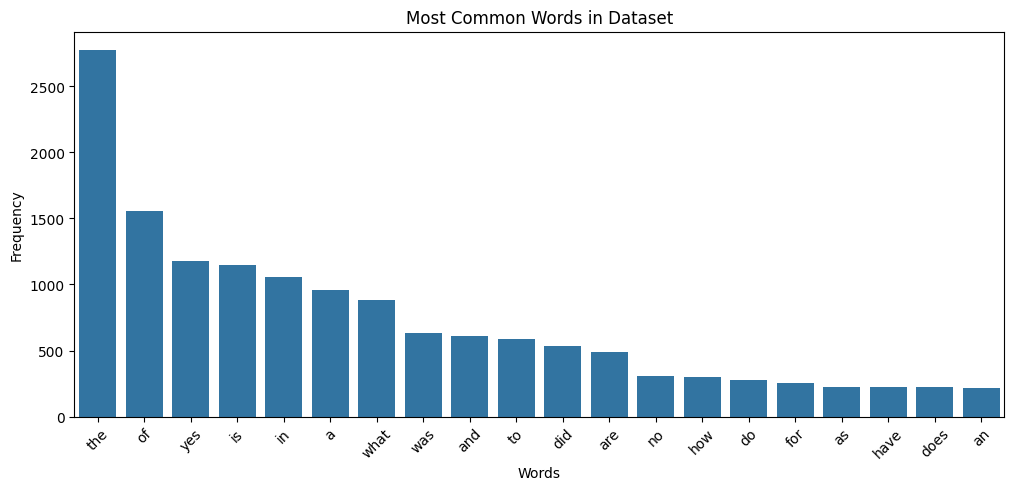

In [155]:
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 5))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common Words in Dataset')
plt.show()

#(Step 6):Build Model with Luong Attention

In [157]:
# Implement Luong Attention

class LuongAttention(layers.Layer):
  def __init__(self, units):
       super(LuongAttention, self).__init__()
       self.latent_dim = latent_dim

  def build(self, inputs_shape):
    print('Received input_shape:', inputs_shape)  # Debugging
    if inputs_shape is None or inputs_shape[0] is None:
      raise ValueError("Invalid Inputs shape received. Ensure the layers get correct input")

  def call(self, inputs): #
      encoder_outputs, hidden_state = inputs #

      # Compute the Attention Scores
      hidden_state_expanded = tf.expand_dims(hidden_state, 1) # Shape batch size
      score = tf.matmul(encoder_outputs, hidden_state_expanded, transpose_b=True) #
      attention_weights = tf.nn.softmax(score, axis=1) # Shape batch size and seq len

      # Compute context vector
      context_vector = tf.matmul(tf.transpose(attention_weights, perm=[0, 2, 1]), encoder_outputs) #dum
      context_vector = tf.squeeze(context_vector, axis=1) # remove extra dimension

      return context_vector, attention_weights

In [158]:
# Define Variables and Dimensions
batch_size = 64
sequence_length = 537 # Length of seqequence = input length
latent_dim = 256
input_dim = vocab_size_input
output_dim = vocab_size_output
embedding_dim = 256

#define Encoder Input
encoder_inputs = layers.Input(shape=(sequence_length,))
decoder_inputs = layers.Input(shape=(sequence_length,))

#Define Enbedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length)

# encoder_output to create a test data
input_seq = tf.random.normal((batch_size, sequence_length))
batch_size = tf.shape(input_seq)[0] if isinstance(input_seq, tf.Tensor) else len(input_seq) # Dynamically get batch
encoder_outputs = tf.random.normal((batch_size, 537, latent_dim)) # 538 was used before
state_h = tf.random.normal((batch_size, latent_dim))

attention_layer = LuongAttention(latent_dim) # create attention
context_vector, attention_weights = attention_layer([encoder_outputs, state_h]) # apply attention

print("Context vector shape:", context_vector.shape)
print("Attenction weightsshape:", attention_weights.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Received input_shape: [(64, 537, 256), (64, 256)]
Context vector shape: (64, 256)
Attenction weightsshape: (64, 537, 1)


#(Step 7): Define the Model Architecture

#Encoder

In [160]:
def build_seq2seq_attention_model(input_dim, output_dim, latent_dim):
  # Encoder
  encoder_inputs = layers.Input(shape=(sequence_length,))
  encoder_embedding = layers.Embedding(input_dim=input_dim, output_dim=latent_dim, mask_zero=True )(encoder_inputs)
  encoder_lstm = layers.LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.3)
  encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

  # Decoder
  decoder_inputs = layers.Input(shape=(sequence_length,))
  decoder_embedding = layers.Embedding(input_dim=output_dim, output_dim=latent_dim, mask_zero=True)(decoder_inputs)
  decoder_lstm = layers.LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3)
  decoder_outputs, _,_ = decoder_lstm(decoder_embedding, initial_state = [state_h, state_c])

# Apply Attention Layer
  context_vector_repeated = Lambda(lambda x: tf.repeat(tf.expand_dims(x[0], axis=1), tf.shape(x[1])[1], axis=1))(
       [context_vector, decoder_outputs]
  )

  decoder_with_context = layers.Concatenate(axis=-1)([decoder_outputs, context_vector_repeated]) # concanate context vector
  decoder_dense_intermediate = layers.Dense(latent_dim, activation='tanh')(decoder_with_context)

  decoder_dense = layers.Dense(output_dim, activation='softmax')(decoder_dense_intermediate)
  decoder_outputs = decoder_dense

  # Define the Model
  model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)   #decoder_outputs)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [161]:
print("attention_weights shape:",attention_weights.shape)
print("encoder_output shape:", encoder_outputs.shape)
print("encoder input shape:", encoder_inputs.shape)


attention_weights shape: (64, 537, 1)
encoder_output shape: (64, 537, 256)
encoder input shape: (None, 537)


In [162]:
# Print out input, output and Latent Dim Values

print(f"Input Dim: {input_dim}, Type: {type(input_dim)}")
print(f"Output Dim: {output_dim}, Type: {type(output_dim)}")
print(f"Latent Dim: {latent_dim}, Type: {type(latent_dim)}")

Input Dim: 5376, Type: <class 'int'>
Output Dim: 5376, Type: <class 'int'>
Latent Dim: 256, Type: <class 'int'>


#(Step 8): Seq2seq Model Attention Summary

In [163]:
# Build the seq2seq model

seq2seq_attention_model = build_seq2seq_attention_model(input_dim, output_dim, latent_dim)
seq2seq_attention_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'lambda_3' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 537)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, 537)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, 537, 256)       │      1,376,256 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_7 (NotEqual)    │ (None, 537)            │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 537, 256)       │      1,376,256 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ [(None, 537, 256),     │        525,312 │ embedding_9[0][0],     │
│                           │ (None, 256), (None,    │                │ not_equal_7[0][0]      │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ [(None, 537, 256),     │        525,312 │ embedding_10[0][0],    │
│                           │ (None, 256), (None,    │                │ lstm_7[0][1],          │
│                           │ 256)]                  │                │ lstm_7[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_8 (NotEqual)    │ (None, 537)            │              0 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (64, 537, 256)         │              0 │ lstm_8[0][0],          │
│                           │                        │                │ not_equal_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 537, 512)       │              0 │ lstm_8[0][0],          │
│ (Concatenate)             │                        │                │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 537, 256)       │        131,328 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 537, 5376)      │      1,381,632 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,316,096 (20.28 MB)

 Trainable params: 5,316,096 (20.28 MB)

 Non-trainable params: 0 (0.00 B)

In [166]:
print(y_train[:3]) # check the first five labels

['at woolsthorpe manor in woosthorpebycolsterworth', 'northern europe', 'yes']


In [167]:
# Run the model to confirm input dim, output dim and latent dim
#model = build_seq2seq_attention_model(input_dim, output_dim, 256)
#model.summary()

In [168]:
# test
#for i, seq in enumerate(input_seq[:5]):
 # (f"Sequence{i}: {seq}, Type: {type(seq)}")

#(Step 9): **Fit** and **train** the **Model**

In [171]:
# Convert list to numpy array

# Define Training Data , Test Data and Validation Data
x_train = [questions]
y_train = [answers]

# Now slice
x_encoder_train = x_train  #[:, :-1] # Encoder input from x_train(questions)
x_decoder_train = y_train #[:, :-1] # Decoder input from y_train (answers)
y_train = y_train #[:, 1:] # Target output shifted to the left

# For Validation:
x_encoder_val = x_val  #[:, :-1] # Encoder val excluding last token
x_decoder_val = y_val #[:, :-1] # Decoder input from y_val
y_val = y_val #[:, 1:] # Target output shifted to the left

#Initialize and fit token on train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(y_train)
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(y_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
y_train_seq = tokenizer.texts_to_sequences(y_train)

# Initiate and fit token on validation data
# Convert the validation sets into sequence data
x_val_seq = tokenizer.texts_to_sequences(x_train)
y_val_seq = tokenizer.texts_to_sequences(y_train)

# Make the lengths equals
max_len = max(max(len(seq) for seq in x_train_seq), max(len(seq) for seq in y_train_seq))
max_len = max(max(len(seq) for seq in x_val_seq), max(len(seq) for seq in y_val_seq))

# Convert the list to integers
x_train_seq = [list(map(int,seq)) for seq in x_train_seq]
y_train_seq = [list(map(int,seq)) for seq in y_train_seq]
x_val_seq = [list(map(int,seq)) for seq in x_val_seq]
y_val_seq = [list(map(int,seq)) for seq in y_val_seq]

# Pad the x_train and y_train
x_train_padded = pad_sequences(x_train_seq, maxlen=538, padding='post', truncating='post') # This equal the length of max_input_len
y_train_padded = pad_sequences(y_train_seq, maxlen=538, padding='post', truncating='post') # This equal the length of max_output_len
#y_train_padded = pad_sequences(y_train, maxlen=538, padding='post', truncating='post')

# Pad the x_val and y_val dataset
x_val_padded = pad_sequences(x_val_seq, maxlen=538, padding='post', truncating='post')
#x_decoder_val_padded = pad_sequences(x_decoder_val, maxlen=538, padding='post', truncating='post')
y_val_padded = pad_sequences(y_val_seq, maxlen=538, padding='post', truncating='post')

# Convert list to Numpy array
x_train_padded = np.array(x_train_padded, dtype=object)
y_train_padded = np.array(y_train_padded, dtype=object)
x_val_padded = np.array(x_val_padded, dtype=object)
y_val_padded = np.array(y_val_padded, dtype=object)

# Now slice the x_train and y_train
x_encoder_train = x_train_padded[:, :-1]
x_decoder_train = y_train_padded[:, :-1]
y_train = y_train_padded[:, 1:] # with a shift or axis

# Slice the validation sets
x_encoder_val = x_val_padded[:, :-1]
x_decoder_val = y_val_padded[:, :-1]
y_val = y_val_padded[:, 1: ] # with a shift or axis

# Print the shapes
print("x_encoder_train shape:", x_encoder_train.shape)
print("x_decoder_train shape:", x_decoder_train.shape)
print("y_train shape:", y_train.shape)
print("x_encoder_val:", x_encoder_val.shape)
print("x_decoder_val:", x_decoder_val.shape)
print("y_val shape:", y_val.shape)

# Print first few elements to inspect
print("\nx_encoder_train sample:\n", x_encoder_train[:2])
print("\nx_decoder_train sample:\n", x_decoder_train[:2])
print("\ny_train sample:\n", y_train[:2])
print("\ny_val sample:", y_val[:2])

x_encoder_train shape: (1, 537)
x_decoder_train shape: (1, 537)
y_train shape: (1, 537)
x_encoder_val: (1, 537)
x_decoder_val: (1, 537)
y_val shape: (1, 537)

x_encoder_train sample:
 [[62 62 63 63 64 64 65 65 66 66 67 67 68 68 69 69 70 70 71 71 72 72 73 73
  74 74 75 75 76 76 77 77 78 78 79 79 1448 1449 1450 1451 1452 1453 1454
  1455 1456 1457 80 80 1458 1459 1460 1461 1462 1463 40 81 1464 40 1465 5
  5 1466 1467 1468 1469 1470 41 82 14 1471 1472 14 1473 41 14 1474 1475 5
  83 83 84 84 85 85 86 86 87 87 88 88 89 89 90 90 91 91 92 92 93 93 94 94
  95 95 96 96 97 97 98 98 99 99 100 100 1476 1477 1478 1479 1480 1481
  1482 1483 1484 1485 1486 1487 101 101 102 102 103 103 104 104 105 105
  106 106 107 107 1488 108 108 109 109 110 110 111 111 112 112 113 113
  114 114 115 115 116 116 117 117 118 118 119 119 120 120 121 121 122 122
  123 123 124 124 125 125 126 126 127 127 128 128 129 129 130 130 1489
  131 131 132 132 133 133 134 134 135 135 136 136 137 137 138 138 139 139
  140 140 141 1

#(Step 10) : Convert and Reshape the Datasets

In [175]:
# Converting training and validation sequences to Numpy integer arrays
x_encoder_train = np.array(x_encoder_train, dtype=np.int32)
x_decoder_train = np.array(x_decoder_train, dtype=np.int32)
y_train = np.array(y_train, dtype=np.int32)

x_encoder_val = np.array(x_encoder_val, dtype=np.int32)
x_decoder_val = np.array(x_decoder_val, dtype=np.int32)
y_val = np.array(y_val, dtype=np.int32)

# Print the New set of shapes
print("New x_encoder_train_reshaped shape:", x_encoder_train.shape)
print("New x_decoder_train_reshaped shape:", x_decoder_train.shape)
print("New y_train reshape shape:", y_train.shape)
print("New x_encoder_val reshape:", x_encoder_val.shape)
print("New x_decoder_val reshape", x_decoder_val.shape)
print("New y_val reshape:", y_val.shape)
print("model outpout shape", model.output_shape)

New x_encoder_train_reshaped shape: (1, 537)
New x_decoder_train_reshaped shape: (1, 537)
New y_train reshape shape: (1, 537)
New x_encoder_val reshape: (1, 537)
New x_decoder_val reshape (1, 537)
New y_val reshape: (1, 537)
model outpout shape (None, 537, 5376)


In [177]:
# Reshapes the training and validation sets
batch_size = 64

if y_train.shape[0] < batch_size:
  y_train = np.tile(y_train, (batch_size // y_train.shape[0] + 1, 1))[:batch_size] # reshape y_train
else:
  y_train = y_train[:batch_size]

if x_encoder_train.shape[0] < batch_size:  # Reshape x_encoder_ train
  x_encoder_train = np.tile(x_encoder_train, (batch_size// x_encoder_train.shape[0] +1, 1))[:batch_size]
else:
  x_encoder_train = x_encoder_train[:batch_size]

if x_decoder_train.shape[0] < batch_size:
  x_decoder_train = np.tile(x_decoder_train, (batch_size// x_decoder_train.shape[0] + 1, 1))[:batch_size]
else:x_decoder_train = x_decoder_train[:batch_size]

if x_encoder_val.shape[0] < batch_size:
  x_encoder_val = np.tile(x_encoder_val, (batch_size// x_encoder_val.shape[0] + 1, 1))[:batch_size]
else:
  x_encoder_val = x_encoder_val[:batch_size]

if x_decoder_val.ndim == 1:
  x_decoder_val = x_decoder_val.reshape(-1, 1) # Convert to 2D before tile

if x_decoder_val.shape[1] != 537:
  x_decoder_val = np.tile(x_decoder_val, (1, 537)) # Expand to (64, 537)

if x_decoder_val.shape[0] < batch_size:
  x_decoder_val = np.tile(x_decoder_val, (batch_size // x_decoder_val.shape[0] + 1, 1))[:batch_size]
else:
  x_decoder_val = x_decoder_val[:batch_size]

  # Ensure Final shape
x_decoder_val = x_decoder_val.reshape(batch_size, 537)

if y_val.shape[0] < batch_size:
  y_val = np.tile(y_val, (batch_size // y_val.shape[0] + 1, 1))[:batch_size]
else:
  y_val = y_val[:batch_size]

print("new x_encoder_train:", x_encoder_train.shape)
print("new x_decoder_train:", x_decoder_train.shape)
print("new y_train shape:", y_train.shape)
print("new x_encoder_val shape:", x_encoder_val.shape)
print("new x_decoder_val shape", x_decoder_val.shape)
print("new y_val shape:", y_val.shape)

new x_encoder_train: (64, 537)
new x_decoder_train: (64, 537)
new y_train shape: (64, 537)
new x_encoder_val shape: (64, 537)
new x_decoder_val shape (64, 537)
new y_val shape: (64, 537)


#(Step 11): Custom Data Generation for Training the Model

In [178]:
# Data Generator for memory efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def data_generator(x_encoder_train, x_decoder_train, y_train,  batch_size):
  size = len(x_encoder_train)
  while True:
    for i in range(0, size, batch_size):
      batch_x_encoder = x_encoder_train[i:i + batch_size]
      batch_x_decoder = x_decoder_train[i:i + batch_size]
      batch_target = y_train[i:i + batch_size]


      # Yield the data as numpy arrays
      yield(np.array(batch_x_encoder), np.array(batch_x_decoder)), np.array(batch_target)

      #yield([batch_x_encoder, batch_x_decoder], batch_target)

# Parameteers for training
batch_size = 64

# Create data generator for training and validation
train_gen = data_generator(x_encoder_train, x_decoder_train, y_train, batch_size)
val_gen = data_generator(x_encoder_val, x_decoder_val, y_val, batch_size)

# Steps per epoch (size of data divide by size of batch)
steps_per_epoch = len(x_encoder_train) // batch_size
validation_steps = len(x_encoder_val) // batch_size

# Training the model using the data generator
history = model.fit(
    train_gen,
    steps_per_epoch = steps_per_epoch,
    epochs = 10,
    validation_data = val_gen,
    validation_steps = validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.3296 - loss: 6.3777 - val_accuracy: 0.3296 - val_loss: 5.8787
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.3296 - loss: 5.8802 - val_accuracy: 0.3296 - val_loss: 5.4275
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.3296 - loss: 5.4291 - val_accuracy: 0.3296 - val_loss: 5.0567
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.3296 - loss: 5.0576 - val_accuracy: 0.3296 - val_loss: 4.7740
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.3296 - loss: 4.7744 - val_accuracy: 0.3296 - val_loss: 4.5614
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.3296 - loss: 4.5616 - val_accuracy: 0.3296 - val_loss: 4.3968
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.3296 - loss: 4.3969 - val_accuracy: 0.3296 - val_loss: 4.2657
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.3296 - loss: 4.2658 - val_accuracy: 0.3296 - val_loss: 4.1612


#(Step 12): Evaluation of the Training Performance (Loss Curve)

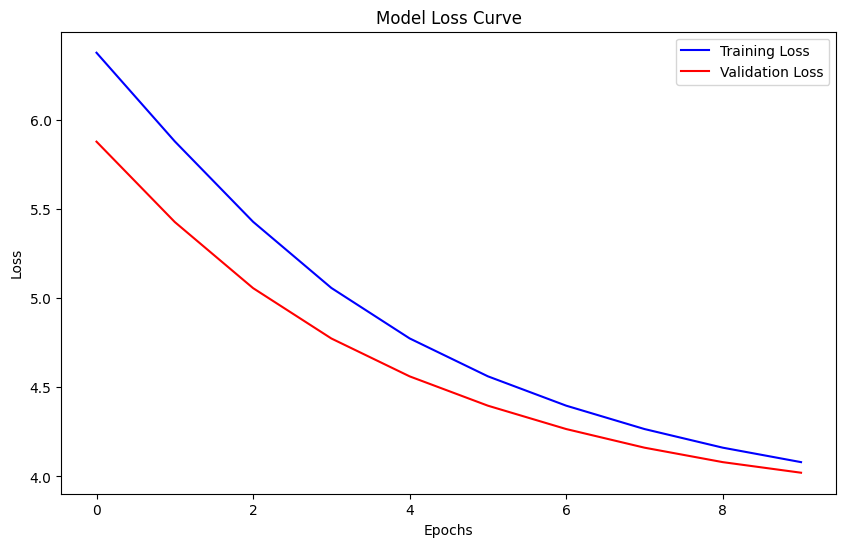

In [179]:
# Convert the training history to Dataframe
history_df = pd.DataFrame(history.history)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_df.index, history_df['loss'], label='Training Loss', color='blue')
plt.plot(history_df.index, history_df['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Curve')
plt.legend()
plt.show()

#Model Evaluation

In [180]:
# Model evaluation on validation data
val_loss, val_accuracy = model.evaluate([x_encoder_val, x_decoder_val], y_val, batch_size=batch_size)

# Print the evaluation results
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.3296 - loss: 4.0206
Validation Loss: 4.020638942718506
Validation Accuracy: 0.3296089470386505


# Calculate the Mean Squared Error and R Score

In [87]:
# Compute Metric Reports
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on the validation data
y_pred = model.predict([x_encoder_val, x_decoder_val], batch_size=batch_size)

# Compute Regression Metrics
#mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


ValueError: Found array with dim 3. None expected <= 2.

#Training Seq2seq Model

In [70]:
# Apply early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#Train the model with early stopping
#history = model.fit(
    #[x_encoder_train, x_decoder_train],
   # x_decoder_train,
   # batch_size=64,
   # epochs=10,
    #validation_data=([x_encoder_val, x_decoder_val], x_decoder_train ),
   # callbacks=[early_stopping]  # Include early stopping callback
#)

#Extract Encoder & Decoder Models for Inference

In [83]:
# Extract Encoder
encoder_inputs = model.input[0]
encoder_outputs, state_h, state_c = model.layers[2].output
encoder_model = Model(encoder_inputs, [state_h, state_c])

# Extract Decoder
decoder_inputs = model.input[1]
decoder_lstm = model.layers[3]
decoder_dense = model.layers[4]

decoder_state_input_h = Input(shape=(538,))
decoder_state_input_c = Input(shape=(538,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs )
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

#Visualize the Model Architecture

In [ ]:
# Plot the Encoder Model
plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(10, 6))
img = plt.imread('encoder_model.png')
plt.imshow(img)
plt.axis('off')
plt.show()

# Plot the Decoder Model
plot_model(decoder_model, to_file = 'decoder_model.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(10, 6))
img = plt.imread('decoder_model.png')
plt.imshow(img)
plt.axis('off')
plt.show()

#Evaluation of the Training Performance (Loss Curve)

In [ ]:
# Convert the training history to DataFrame
history_df = pd.DataFrame(history.history)

# Plot Training & Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_df.index, history_df['loss'], label= 'Training Loss', color='blue')
plt.plot(history_df.index, history_df['val_loss'], label= 'Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Curve')
plt.legend()
plt.show()

#Define the Chabot with Luong Attention Response Function

In [ ]:
# Define the chatbot
def generate_response(input_text, encoder_model, decoder_model, tokenizer, max_len=538):
  input_seq = tokenizer.texts_to_sequences([input_text])
  input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')

  # Encode the input sentence
  states_value = encoder_model.predict(input_seq)

  # Start token for decoding
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = tokenizer.word_index['<start>']

  stop_condition = False
  decoded_sentence = []

  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_word = tokenizer.index_word.get(sampled_token_index, '')

    if sampled_word == '<end>' or len(decoded_sentence) > max_len:
      stop_condition = True
    else:
      decoded_sentence.append(sampled_word)

    target_seq[0, 0] = sampled_token_index
    states_value = [h, c]

  return ' '.join(decoded_sentence)

#Test the Chatbot with Different User Inputs

In [ ]:
# Perform a test run of the chatbot
sample_question = "Hello, how are you?"
response = generate_response(sample_question, encoder_model, decoder_model, tokenizer)
print(f"User: {sample_question}")
print(f"Chatbot: {response}")

#Evaluate Chatbot Performance Using BLEU Score

In [ ]:
# Compare the chatbot's feedback with reference to input questions
def evaluate_bleu_score(reference, candidate):
  reference = [reference.split()]
  candidate = candidate.split()
  score = sentence_bleu(reference, candidate)
  return score

#Sample BLEU Score Calculation

In [ ]:
reference_text = "hello how are you?"
candidate_text = "hello how are you"

bleu_score = evaluate_bleu_score(reference_text, candidate_text)
print(f"BLEU Score: {bleu_score:.4f}")

#**END** OF **PROJECT**